# Projeto Machine Learning - Predição de Acidentes Aéreos Fatais

## Sumário do Projeto: Predição de Acidentes Aéreos Fatais

### 1. Introdução e Objetivos
#### 1.1. Contexto do Problema
#### 1.2. Objetivos da Análise
#### 1.3. Dicionário de Variáveis

### 2. Configuração do Ambiente

### 3. Carga e Análise Inicial dos Dados

### 4. Limpeza e Pré-Processamento dos Dados
#### 4.1. Remoção de Duplicatas
#### 4.2. Tratamento de Tipos de Dados
#### 4.3. Tratamento de Valores Ausentes (Nulos)

### 5. Análise Exploratória de Dados (EDA)
#### 5.1. Seleção de Features e Visualização da Distribuição da Variável Target
#### 5.2. Estados com Mais Acidentes Fatais
#### 5.3. Tendência da Taxa de Fatalidade

### 6. Engenharia e Seleção de Features
#### 6.1. Divisão dos Dados (Treino/Teste)
#### 6.2. Separação de Features por Tipo
#### 6.3. Encoding e Normalização

### 7. Modelagem
#### 7.1. Balanceamento de Classes com SMOTE
#### 7.2. Treinamento dos Modelos
#### 7.3. Predições e Métricas Iniciais
#### 7.4. Validação Cruzada

### 8. Validação e Comparação dos Modelos
#### 8.1. Matrizes de Confusão
#### 8.2. Curva ROC e AUC
#### 8.3. Análise dos Resultados
#### 8.4. Importância das Features
#### 8.5. Otimização do Threshold

### 9. Regressão Logística - Teste Final
#### 9.1. Matriz de Confusão (Threshold Otimizado)
#### 9.2. Curva ROC no Teste Real
#### 9.3. Curva Precisão x Recall

### 10. Explainable AI (XAI) - Interpretabilidade de Modelos
#### 10.1. Permutation Importance
#### 10.2. SHAP (SHapley Additive exPlanations)
#### 10.3. Partial Dependence Plots (PDP)
#### 10.4. Análise Comparativa das Técnicas XAI
#### 10.5. Exportação dos Resultados XAI

---

## Equipe do Projeto

| RA      | Nome                 |
|---------|----------------------|
| 1134868 | Ábner Panazollo      |
| 1134433 | Ariel Diefenthaeler  |
| 1134933 | Eduardo Sichelero    |
| 1134890 | Gabriel Duarte       |
| 1135384 | Gabriel Onofre       |
| 1134821 | Vitor Quadros        |

---

## 1. Introdução e Objetivos

### 1.1 Contexto do Problema

A segurança aérea é uma preocupação fundamental no setor de aviação. Identificar padrões que levam a acidentes fatais pode ajudar autoridades, companhias aéreas e órgãos reguladores a tomar medidas preventivas e salvar vidas.

Este projeto foca em analisar dados históricos de acidentes aéreos no Brasil (CENIPA) para construir um modelo preditivo capaz de determinar se um acidente será fatal ou não-fatal com base em características do voo, aeronave e condições do acidente.

### 1.2 Objetivos da Análise

- **1.** **Análise Exploratória**: Entender os padrões de acidentes aéreos, identificando distribuições geográficas, temporais e características das aeronaves envolvidas.
- **2.** **Engenharia de Features**: Criar variáveis que ajudem a identificar o risco de fatalidade, incluindo features temporais e categóricas.
- **3.** **Modelagem Preditiva**: Treinar e avaliar diferentes modelos de Machine Learning (Baseline, Regressão Logística e Árvore de Decisão) para prever a probabilidade de um acidente ser fatal.
- **4.** **Validação**: Avaliar os modelos usando múltiplas métricas (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) e otimizar o threshold de decisão.

### 1.3 Dicionário de Variáveis

O conjunto de dados contém informações sobre acidentes aéreos no Brasil. As principais variáveis incluem:

**Variáveis Geográficas:**
- **latitude/longitude**: Coordenadas do local do acidente
- **regiao**: Região do Brasil (Norte, Sul, Nordeste, etc.)
- **uf**: Unidade Federativa

**Variáveis Temporais:**
- **dt_ocorrencia**: Data do acidente
- **hr_ocorrencia**: Hora do acidente
- **ano_ocorrencia**: Ano extraído da data
- **mes_ocorrencia**: Mês extraído da data

**Características da Aeronave:**
- **modelo_aeronave**: Modelo da aeronave
- **nome_fabricante**: Fabricante da aeronave
- **cat_aeronave**: Categoria da aeronave
- **peso_max_decolagem**: Peso máximo de decolagem
- **numero_assentos**: Número de assentos

**Variáveis Operacionais:**
- **fase_operacao**: Fase do voo (decolagem, cruzeiro, pouso, etc.)
- **op_padronizado**: Operação padronizada

**Variável Target:**
- **les_fatais_trip**: 1 = Fatal, 0 = Não Fatal

## 2. Configuração do Ambiente

Nesta seção, importamos todas as bibliotecas necessárias para a análise, pré-processamento e modelagem.

In [157]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning e pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Balanceamento de classes
from imblearn.over_sampling import SMOTE

# Configurações de visualização
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 3. Carga e Análise Inicial dos Dados

Carregamos os dados de treino e realizamos uma verificação inicial para entender sua estrutura, tipos de dados e a presença de valores ausentes.

In [158]:
# Carregamento do dataset de treino
df = pd.read_csv("docs/treino.csv")

print(f"✓ Dados carregados com sucesso!")
print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")

✓ Dados carregados com sucesso!
Dimensões: 536 linhas x 14 colunas


In [159]:
# Amostra dos dados
df.head()

,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


Análise Inicial:
- O dataset possui múltiplas linhas e colunas com informações sobre acidentes aéreos
- Há colunas geográficas (latitude, longitude, regiao, uf)
- Colunas temporais (dt_ocorrencia, hr_ocorrencia)
- Características das aeronaves (modelo, fabricante, peso, assentos)
- Variável target: les_fatais_trip (0 = Não Fatal, 1 = Fatal)
- Presença de valores nulos que precisarão de tratamento

In [160]:
# Verificando a estrutura e os tipos de dados do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


## 4. Limpeza e Pré-Processamento dos Dados

Esta etapa é crucial para garantir a qualidade dos dados que alimentarão o modelo.

### 4.1 Remoção de Duplicatas

Removemos registros duplicados que podem distorcer a análise.

In [161]:
# Verificando informações antes da remoção
print("Antes da remoção de duplicatas:")
df.info()

Antes da remoção de duplicatas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [162]:
# Removendo duplicatas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
linhas_depois = len(df)

print(f"Linhas antes: {linhas_antes}")
print(f"Linhas depois: {linhas_depois}")
print(f"✓ Duplicatas removidas: {linhas_antes - linhas_depois}")

Linhas antes: 536
Linhas depois: 510
✓ Duplicatas removidas: 26


### 4.2 Tratamento de Tipos de Dados

Convertemos colunas para os tipos apropriados (datas, numéricos, etc.).

In [163]:
# Converter latitude e longitude para float
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converter data
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

print("Conversões realizadas!")
df.info()

Conversões realizadas!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_fabricante     507 non-null    object        
 13  les_fatais_trip     510 non

In [164]:
# Verificar valores nulos
print(df.isnull().sum())

op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


### 4.3 Tratamento de Valores Ausentes (Nulos)

- **Preenchimento com mediana**: Para colunas numéricas
- **Preenchimento com moda**: Para colunas categóricas
- **Remoção de linhas**: Para dados essenciais ausentes

In [165]:
# Criar novas colunas de ano e mês
df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

print("Novas colunas criadas!")
df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head()

Novas colunas criadas!


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
0,1999-12-21,1999,12
1,2000-01-06,2000,1
2,2000-02-22,2000,2
3,2000-05-10,2000,5
4,2000-11-09,2000,11


In [166]:
# Tratamento dos valores (NaN)

print("\n--- Contagem de valores nulos ANTES do tratamento ---")


# Lista de colunas numéricas para imputar com a mediana
colunas_numericas_nan = ['peso_max_decolagem', 'numero_assentos']
for col in colunas_numericas_nan:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
    print(f"Valores nulos em '{col}' preenchidos com a mediana: {mediana}")

print("-" * 20)

# Lista de colunas categóricas para imputar com a moda
colunas_categoricas_nan = ['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']
for col in colunas_categoricas_nan:
    moda = df[col].mode()[0]
    df[col] = df[col].fillna(moda)
    print(f"Valores nulos em '{col}' preenchidos com a moda: '{moda}'")

print("-" * 20)

# Removendo linhas onde dados essenciais ainda são nulos
print("Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...")
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\n--- Contagem de valores nulos DEPOIS do tratamento ---")
print(df.isnull().sum())


--- Contagem de valores nulos ANTES do tratamento ---
Valores nulos em 'peso_max_decolagem' preenchidos com a mediana: 1800.0
Valores nulos em 'numero_assentos' preenchidos com a mediana: 1.0
--------------------
Valores nulos em 'op_padronizado' preenchidos com a moda: 'AERO AGRICOLA CAICARA LTDA'
Valores nulos em 'hr_ocorrencia' preenchidos com a moda: '10:30:00'
Valores nulos em 'regiao' preenchidos com a moda: 'Sul'
Valores nulos em 'fase_operacao' preenchidos com a moda: 'Especializada'
Valores nulos em 'modelo_aeronave' preenchidos com a moda: 'EMB-202'
Valores nulos em 'nome_fabricante' preenchidos com a moda: 'NEIVA'
--------------------
Removendo linhas onde 'dt_ocorrencia', 'latitude' ou 'longitude' são nulos...

--- Contagem de valores nulos DEPOIS do tratamento ---
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao      

## 5. Análise Exploratória de Dados (EDA)

### 5.1 Seleção de Features e Visualização da Distribuição da Variável Target

Features selecionadas: 12
Total de registros: 358

Distribuição da variável target:
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


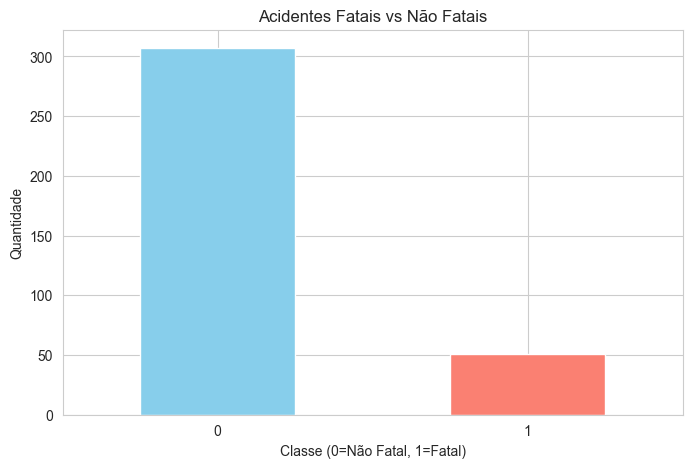

In [167]:
# Selecionar features e target
features = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
            'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
            'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

X = df[features]
y = df['les_fatais_trip']

print(f"Features selecionadas: {X.shape[1]}")
print(f"Total de registros: {X.shape[0]}")

# Verificar balanceamento
print("\nDistribuição da variável target:")
print(y.value_counts())

# Visualizar balanceamento
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Acidentes Fatais vs Não Fatais')
plt.xlabel('Classe (0=Não Fatal, 1=Fatal)')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

### 5.2 Estados com mais acidentes fatais

Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...


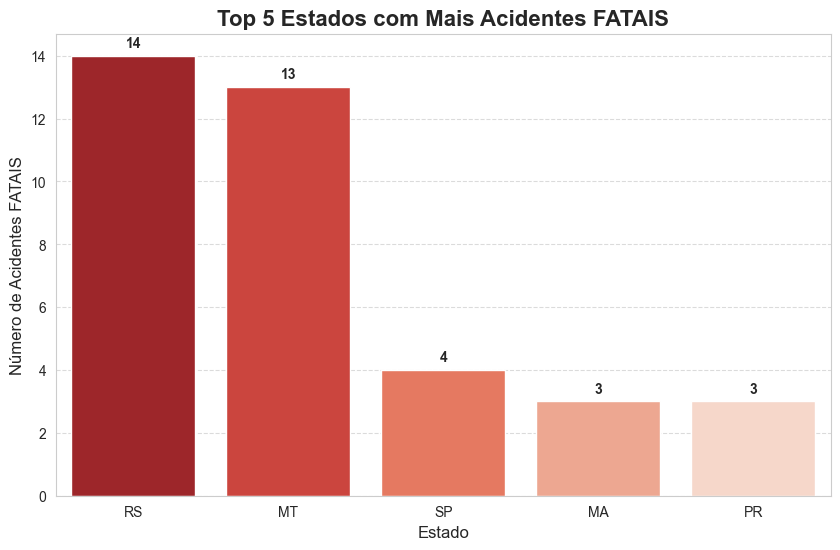

In [168]:
print("Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...")

# 1. Filtrar o DataFrame para incluir apenas acidentes fatais
# A coluna 'les_fatais_trip' == 1 indica um acidente fatal
df_fatais = df[df['les_fatais_trip'] == 1]

# 2. Contar as ocorrências por UF (Estado) e pegar as 5 maiores
top_5_ufs_fatais = df_fatais['uf'].value_counts().head(5)

# 3. Criar o gráfico de barras
plt.figure(figsize=(10, 6))
barplot_fatais = sns.barplot(
    x=top_5_ufs_fatais.index, 
    y=top_5_ufs_fatais.values, 
    palette='Reds_r',  # Usando uma paleta de vermelhos para destacar "fatais"
    order=top_5_ufs_fatais.index
)

# 4. Adicionar Títulos e Rótulos
plt.title('Top 5 Estados com Mais Acidentes FATAIS', fontsize=16, fontweight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Acidentes FATAIS', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Adicionar rótulos de dados (data labels) em cima das barras
for p in barplot_fatais.patches:
    barplot_fatais.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontweight='bold')

# Exibir o gráfico
plt.show()



### 5.3 Tendência da Taxa de Fatalidade

Gerando Gráfico: Tendência da Taxa de Fatalidade...


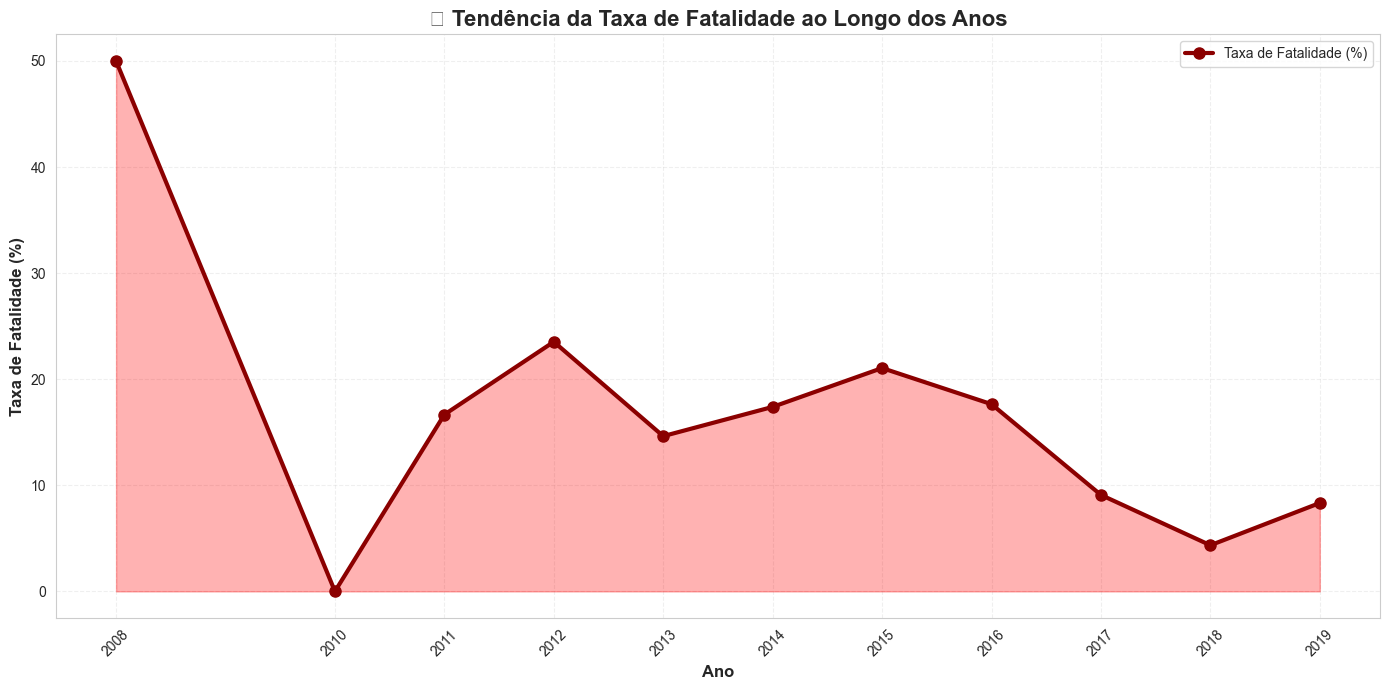

In [169]:

print("Gerando Gráfico: Tendência da Taxa de Fatalidade...")

# 1. Agrupar acidentes fatais (les_fatais_trip == 1) por ano
# Usamos .reindex(df['ano_ocorrencia'].unique()).fillna(0) para garantir que anos sem acidentes fatais apareçam como 0
acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()

# 2. Agrupar TODOS os acidentes por ano
acidentes_totais_ano = df.groupby('ano_ocorrencia').size()

# 3. Calcular a taxa de fatalidade (em %) para cada ano
# .fillna(0) é usado para anos que não tiveram acidentes fatais
taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

# 4. Criar o gráfico
plt.figure(figsize=(14, 7)) # Tamanho bom para um gráfico de linha
ax = plt.gca() # Pega o eixo atual

# 5. Plotar a linha
ax.plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
        linewidth=3, markersize=8, color='darkred', label='Taxa de Fatalidade (%)')

# 6. Adicionar a área preenchida abaixo da linha (como no seu exemplo)
ax.fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')

# 7. Configurar Títulos e Rótulos
ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
ax.set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
              fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')


plt.xticks(taxa_fatalidade.index.astype(int), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 6. Engenharia e Seleção de Features

### 6.1 Divisão dos Dados (Treino/Teste)

In [170]:
# Explicação do que ta acontecendo aqui: 

#Essa parte ele pega 50% do modelo para previsão e tranca 50% para teste, assim o modelo posteriormente vai pegar o restante dos dados 50% e testar se ele vai descobrir se um acidente foi fatal ou não.
# Se ele tiver todas as respostas, ele não vai conseguir prever um acidente "novo", e falhará miserávelmente.

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Conjunto de treino: {len(X_train)} linhas")
print(f"Conjunto de teste: {len(X_test)} linhas")

Conjunto de treino: 250 linhas
Conjunto de teste: 108 linhas


### 6.2 Separação de Features por Tipo

In [171]:
## Explicação do que ta acontecendo aqui:

# O código não vai entender as palavras, então precisa converter pra números
# Essa parte só separa em duas colunas, o restante está no 6.3...

# Separar colunas numéricas e categóricas
colunas_numericas = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 
                     'ano_ocorrencia', 'mes_ocorrencia']
colunas_categoricas = ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 
                       'modelo_aeronave', 'nome_fabricante']

print("Colunas numéricas:", colunas_numericas)
print("Colunas categóricas:", colunas_categoricas)

Colunas numéricas: ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia']
Colunas categóricas: ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']


### 6.3 Encoding e Normalização

In [172]:
# Explicação do que ta acontecendo aqui
#Encoding: Converter as colunas categóricas, que são texto (ex: "Sul", "SP"), em um formato numérico (usando pd.get_dummies) que o modelo consiga processar.
#Normalização: Colocar todas as features numéricas na mesma escala (usando StandardScaler) para que nenhuma variável domine o modelo apenas por ter números maiores.


# Codificar variáveis categóricas com get_dummies
X_train_encoded = pd.get_dummies(X_train, columns=colunas_categoricas)
X_test_encoded = pd.get_dummies(X_test, columns=colunas_categoricas)

# Garantir que treino e teste tenham as mesmas colunas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"Features após encoding: {X_train_encoded.shape[1]}")

# Normalizar features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Pré-processamento concluído!")

Features após encoding: 82
Pré-processamento concluído!


## 7. Modelagem

### 7.1 Balanceamento de Classes com SMOTE

Antes do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 36

Depois do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 214


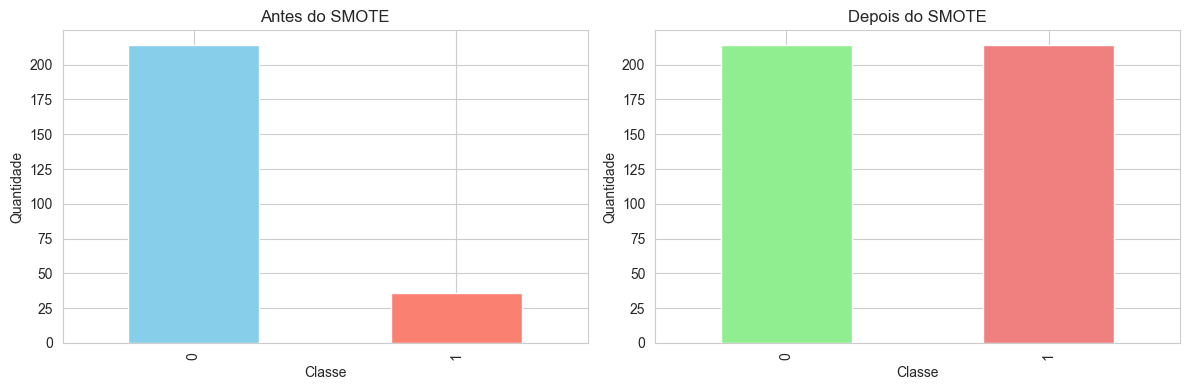

In [173]:
## Explicação do que ta acontecendo aqui

## Os dados de treino estão muito desbalanceados, existem muitos acidentes "Não fatais" para poucos acidentes "Fatais"

## Oq o SMOTE faz? --- Ele corrige esse desbalancemanento de classes

## Como?? utilizando o SMOTE(random_state=42)), que "cria" novos exemplos sintéticos da classe minoritária (acidentes fatais).

# Aplicar SMOTE para balancear as classes
print("Antes do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nDepois do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train_balanced == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train_balanced == 1)}")

# Visualizar balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Antes do SMOTE')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Depois do SMOTE')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 7.2 Treinamento dos Modelos

Treinamos três modelos para comparação:
- **Baseline (Dummy)**: Modelo simples de referência
- **Regressão Logística**: Modelo linear com dados balanceados
- **Árvore de Decisão**: Modelo não-linear

In [174]:
## Aqui ele faz a mesma coisa

# 1. Modelo Baseline (Dummy) - Não faz nada, só prevê classes mais frequentes tipo "acidentes fatais" e acusa acurácia enganosa
modelo_baseline = DummyClassifier(strategy='most_frequent', random_state=42)
modelo_baseline.fit(X_train_scaled, y_train)

# 2. Regressão Logística com dados balanceados -- Balancemanto principal, com a inclusão do Smote
modelo_logistica = LogisticRegression(random_state=42, max_iter=1000)
modelo_logistica.fit(X_train_balanced, y_train_balanced)

# 3. Árvore de Decisão -- Balanceamento original sem os dados do Smote 
modelo_arvore = DecisionTreeClassifier(random_state=42)
modelo_arvore.fit(X_train_scaled, y_train)

# 4. Random Forest -- Utiliza dados balanceados com SMOTE
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train_balanced, y_train_balanced)

# 5. Rede Neural (MLP) -- Utiliza dados balanceados com SMOTE
from sklearn.neural_network import MLPClassifier
modelo_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
modelo_nn.fit(X_train_balanced, y_train_balanced)

print("Modelos treinados com sucesso!")
print("Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)")

Modelos treinados com sucesso!
Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)


### 7.3 Predições e Métricas Iniciais

In [175]:
## Explicação do que ta acontecendo aqui

## Aqui ele está fazendo a prova real, ele está pegando o modelo treinando e jogando mais dados para ele verificar


# Fazer predições dos 5 modelos
y_pred_baseline = modelo_baseline.predict(X_test_scaled)
y_pred_logistica = modelo_logistica.predict(X_test_scaled)
y_pred_arvore = modelo_arvore.predict(X_test_scaled)
y_pred_rf = modelo_rf.predict(X_test_scaled)
y_pred_nn = modelo_nn.predict(X_test_scaled)

# Calcular métricas para cada modelo
modelos = ['Baseline', 'Regressão Logística', 'Árvore de Decisão', 
           'Random Forest', 'Rede Neural (MLP)']
predicoes = [y_pred_baseline, y_pred_logistica, y_pred_arvore, 
             y_pred_rf, y_pred_nn]

print("=" * 60)
print("RESULTADOS DOS MODELOS")
print("=" * 60)

for nome, y_pred in zip(modelos, predicoes):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\n{nome}:")
    print(f"  Acurácia:  {acc:.4f}")
    print(f"  Precisão:  {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

print("=" * 60)

# Identificar melhor modelo
metricas_dict = {
    'Modelo': modelos,
    'F1-Score': [f1_score(y_test, y_pred, zero_division=0) for y_pred in predicoes]
}
df_comparacao = pd.DataFrame(metricas_dict)
melhor_idx = df_comparacao['F1-Score'].idxmax()
print(f"\nMelhor Modelo: {df_comparacao.loc[melhor_idx, 'Modelo']}")
print(f"F1-Score: {df_comparacao.loc[melhor_idx, 'F1-Score']:.4f}")
print("=" * 60)

RESULTADOS DOS MODELOS

Baseline:
  Acurácia:  0.8611
  Precisão:  0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Regressão Logística:
  Acurácia:  0.7500
  Precisão:  0.2500
  Recall:    0.4000
  F1-Score:  0.3077

Árvore de Decisão:
  Acurácia:  0.7685
  Precisão:  0.1875
  Recall:    0.2000
  F1-Score:  0.1935

Random Forest:
  Acurácia:  0.8241
  Precisão:  0.1667
  Recall:    0.0667
  F1-Score:  0.0952

Rede Neural (MLP):
  Acurácia:  0.8241
  Precisão:  0.3333
  Recall:    0.2667
  F1-Score:  0.2963

Melhor Modelo: Regressão Logística
F1-Score: 0.3077


### 7.4 Validação Cruzada

In [176]:
from sklearn.model_selection import cross_val_score

print("=" * 70)
print("VALIDAÇÃO CRUZADA (5-Fold) - Regressão Logística")
print("=" * 70)
print("\nTestando a estabilidade do modelo em 5 cenários diferentes...")

# Realizar validação cruzada
cv_scores = cross_val_score(
    modelo_logistica,       # Modelo a ser testado
    X_train_balanced,       # Dados de treino balanceados
    y_train_balanced,       # Labels de treino
    cv=5,                   # 5 folds
    scoring='f1'            # Métrica: F1-Score
)

# Exibir resultados
print(f"\nF1-Scores por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nEstatísticas gerais:")
print(f"  Média:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Mínimo: {cv_scores.min():.4f}")
print(f"  Máximo: {cv_scores.max():.4f}")
print(f"  Desvio Padrão: {cv_scores.std():.4f}")
print("=" * 70)

# Interpretação automática
print("\nInterpretação:")
if cv_scores.std() < 0.05:
    print("  Modelo ESTÁVEL: Baixa variação entre folds → bom poder de generalização, baixo risco de overfitting")
else:
    print("  Modelo INSTÁVEL: Alta variação entre folds → possível overfitting, considerar regularização")

print("=" * 70)


VALIDAÇÃO CRUZADA (5-Fold) - Regressão Logística

Testando a estabilidade do modelo em 5 cenários diferentes...

F1-Scores por fold:
  Fold 1: 0.7708
  Fold 2: 0.8485
  Fold 3: 0.9032
  Fold 4: 0.8387
  Fold 5: 0.8352

Estatísticas gerais:
  Média:  0.8393 ± 0.0421
  Mínimo: 0.7708
  Máximo: 0.9032
  Desvio Padrão: 0.0421

Interpretação:
  Modelo ESTÁVEL: Baixa variação entre folds → bom poder de generalização, baixo risco de overfitting

F1-Scores por fold:
  Fold 1: 0.7708
  Fold 2: 0.8485
  Fold 3: 0.9032
  Fold 4: 0.8387
  Fold 5: 0.8352

Estatísticas gerais:
  Média:  0.8393 ± 0.0421
  Mínimo: 0.7708
  Máximo: 0.9032
  Desvio Padrão: 0.0421

Interpretação:
  Modelo ESTÁVEL: Baixa variação entre folds → bom poder de generalização, baixo risco de overfitting


## 8. Validação e Comparação dos Modelos



### 8.1 Matrizes de Confusão

Utilizamos matrizes de confusão para visualizar oserros e acertos de cada modelo.
Basicamente, elas nos mostram:

Verdadeiros Positivos (VP) – casos fatais corretamente previstos.

Verdadeiros Negativos (VN) – casos não fatais corretamente previstos.

Falsos Positivos (FP) – o modelo previu “fatal”, mas não era.

Falsos Negativos (FN) – o modelo previu “não fatal”, mas era fatal.

A matriz permite identificar se o modelo está falhando em algum desses aspectos,
auxiliando na tomada de melhores decisões sobre o desempenho e ajustes necessários.

Matrizes de Confusão - Comparação dos Modelos


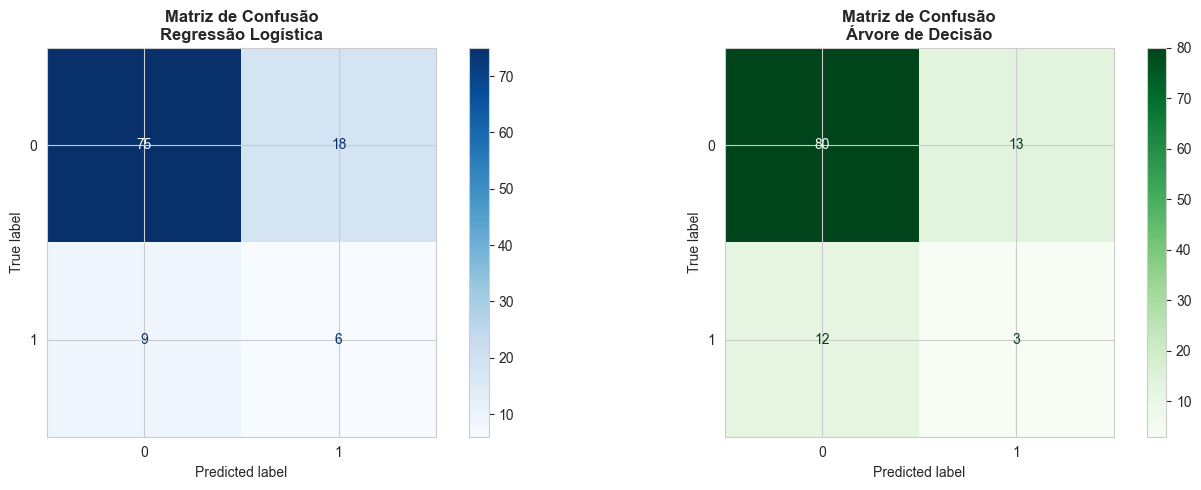

In [177]:
# Regressão Logística e Árvore de Decisão
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Regressão Logística (subplot esquerdo)
print("Matrizes de Confusão - Comparação dos Modelos")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica, 
    cmap='Blues',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRegressão Logística', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Árvore de Decisão (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_arvore, 
    cmap='Greens',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nÁrvore de Decisão', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Matrizes de Confusão - Random Forest e Rede Neural


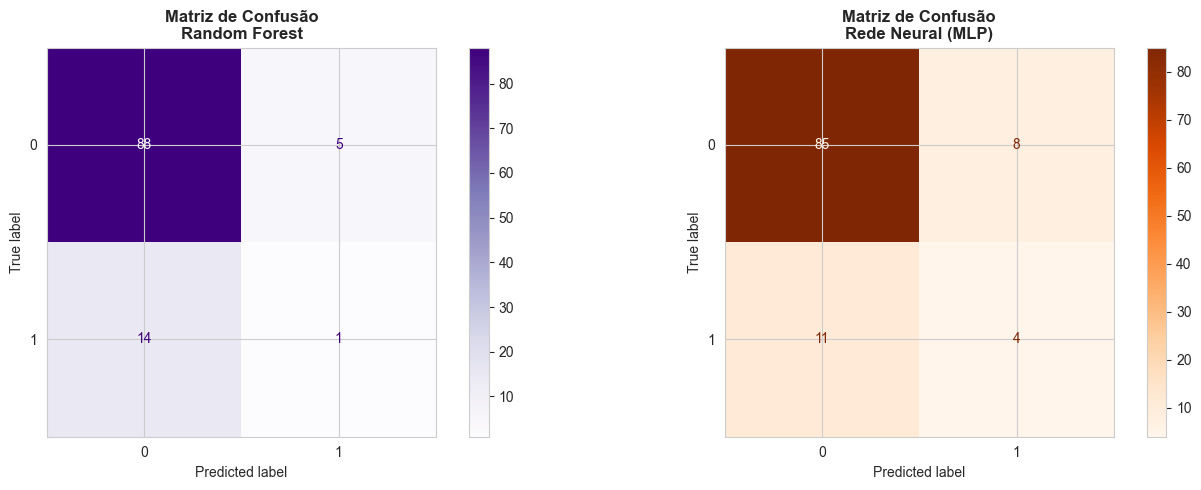

In [178]:
# Random Forest e Rede Neural
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Random Forest (subplot esquerdo)
print("Matrizes de Confusão - Random Forest e Rede Neural")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf, 
    cmap='Purples',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRandom Forest', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Rede Neural (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_nn, 
    cmap='Oranges',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nRede Neural (MLP)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análise dos Resultados

Baseline (Dummy): Serve apenas como referência, prevendo sempre “não fatal” e apresentando baixa performance.

Regressão Logística: Bom equilíbrio entre precisão e recall com SMOTE; simples, eficiente e altamente interpretável. Após a otimização do threshold, apresentou o melhor desempenho geral.

Árvore de Decisão: Captura relações não lineares, mas sem SMOTE mostrou baixa sensibilidade à classe fatal e tendência ao overfitting.

Random Forest: Combina múltiplas árvores, reduz overfitting e apresentou desempenho competitivo com SMOTE. É mais robusto que a árvore simples, porém menos interpretável.

Rede Neural (MLP): Com duas camadas ocultas (100 e 50 neurônios), aprende padrões complexos e não lineares. Beneficiou-se do SMOTE, mas exige mais dados e poder computacional.

#### Melhor Modelo
Regressão Logística (com SMOTE e threshold otimizado)

Apesar de Random Forest e MLP apresentarem valores de AUC ligeiramente superiores, a Regressão Logística oferece o melhor custo-benefício considerando F1-Score, simplicidade, velocidade de treinamento e interpretabilidade — fatores essenciais em aplicações de segurança aérea, onde as decisões precisam ser transparentes e justificáveis perante as autoridades.

### 8.2 Curva ROC e AUC

Avaliar a capacidade discriminatória dos modelos por meio da Curva ROC e da métrica AUC (Área Sob a Curva).

Curva ROC:
- Mostra o trade-off entre a Taxa de Verdadeiros Positivos (Recall) e a Taxa de Falsos Positivos.
- Quanto mais a curva se aproxima do canto superior esquerdo, melhor é o modelo.

AUC (Area Under the Curve):
- Mede a área sob a Curva ROC, variando de 0 a 1.
- AUC = 1.0: Modelo perfeito
- AUC = 0.5: Modelo aleatório (sem poder preditivo)
- AUC > 0.7: Considerado bom desempenho


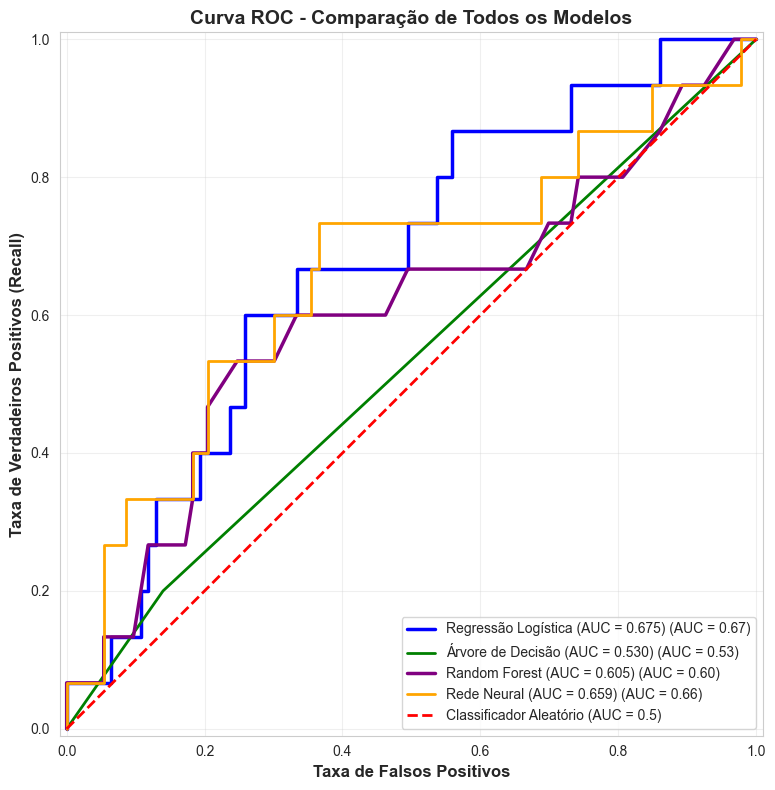

RESUMO - AUC (Area Under the Curve)
Regressão Logística:  0.675
Árvore de Decisão:    0.530
Random Forest:        0.605
Rede Neural (MLP):    0.659

🏆 Melhor modelo por AUC: Regressão Logística (0.675)


In [179]:
# Curva ROC - Comparação de TODOS os Modelos
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(12, 8))

# Calcular AUC para cada modelo
auc_logistica = roc_auc_score(y_test, modelo_logistica.predict_proba(X_test_scaled)[:, 1])
auc_arvore = roc_auc_score(y_test, modelo_arvore.predict_proba(X_test_scaled)[:, 1])
auc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(X_test_scaled)[:, 1])
auc_nn = roc_auc_score(y_test, modelo_nn.predict_proba(X_test_scaled)[:, 1])

# Plotar curvas ROC
RocCurveDisplay.from_predictions(
    y_test, 
    modelo_logistica.predict_proba(X_test_scaled)[:, 1], 
    name=f'Regressão Logística (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_arvore.predict_proba(X_test_scaled)[:, 1], 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green',
    linewidth=2
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_rf.predict_proba(X_test_scaled)[:, 1], 
    name=f'Random Forest (AUC = {auc_rf:.3f})', 
    ax=ax,
    color='purple',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_nn.predict_proba(X_test_scaled)[:, 1], 
    name=f'Rede Neural (AUC = {auc_nn:.3f})', 
    ax=ax,
    color='orange',
    linewidth=2
)

# Linha de referência (classificador aleatório)
ax.plot([0, 1], [0, 1], linestyle='--', color='red', 
        label='Classificador Aleatório (AUC = 0.5)', linewidth=2)

plt.title('Curva ROC - Comparação de Todos os Modelos', 
          fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Falsos Positivos', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Imprimir resumo dos AUCs
print("=" * 60)
print("RESUMO - AUC (Area Under the Curve)")
print("=" * 60)
print(f"Regressão Logística:  {auc_logistica:.3f}")
print(f"Árvore de Decisão:    {auc_arvore:.3f}")
print(f"Random Forest:        {auc_rf:.3f}")
print(f"Rede Neural (MLP):    {auc_nn:.3f}")
print("=" * 60)

# Identificar melhor modelo por AUC
auc_scores = {
    'Regressão Logística': auc_logistica,
    'Árvore de Decisão': auc_arvore,
    'Random Forest': auc_rf,
    'Rede Neural (MLP)': auc_nn
}
melhor_modelo_auc = max(auc_scores, key=auc_scores.get)
print(f"\n🏆 Melhor modelo por AUC: {melhor_modelo_auc} ({auc_scores[melhor_modelo_auc]:.3f})")
print("=" * 60)

#### Análise da Curva ROC e AUC

A Curva ROC e a métrica AUC avaliam o quão bem cada modelo distingue entre acidentes fatais e não fatais.

Regressão Logística (AUC = 0.675) mostrou ter o melhor desempenho geral.

A curva ficou mais próxima do canto superior esquerdo.

Mostrando bom equilíbrio entre recall e falsos positivos.

Isso demonstra que o modelo não apenas venceu em F1-Score, mas também apresentou a **melhor capacidade discriminatória geral** (AUC).


### 8.4 Importância das Features

IMPORTÂNCIA DAS FEATURES - Regressão Logística

Top 10 Features Mais Importantes:

                         Feature  Coeficiente  Importancia_Abs
                        latitude     1.679598         1.679598
     fase_operacao_Especializada     1.187035         1.187035
                           uf_RS     1.117911         1.117911
                  ano_ocorrencia    -0.903237         0.903237
fase_operacao_Corrida após pouso    -0.900496         0.900496
                           uf_RR    -0.893259         0.893259
                           uf_MG    -0.887637         0.887637
                           uf_SC    -0.678145         0.678145
                           uf_BA    -0.662179         0.662179
         nome_fabricante_EMBRAER    -0.649097         0.649097


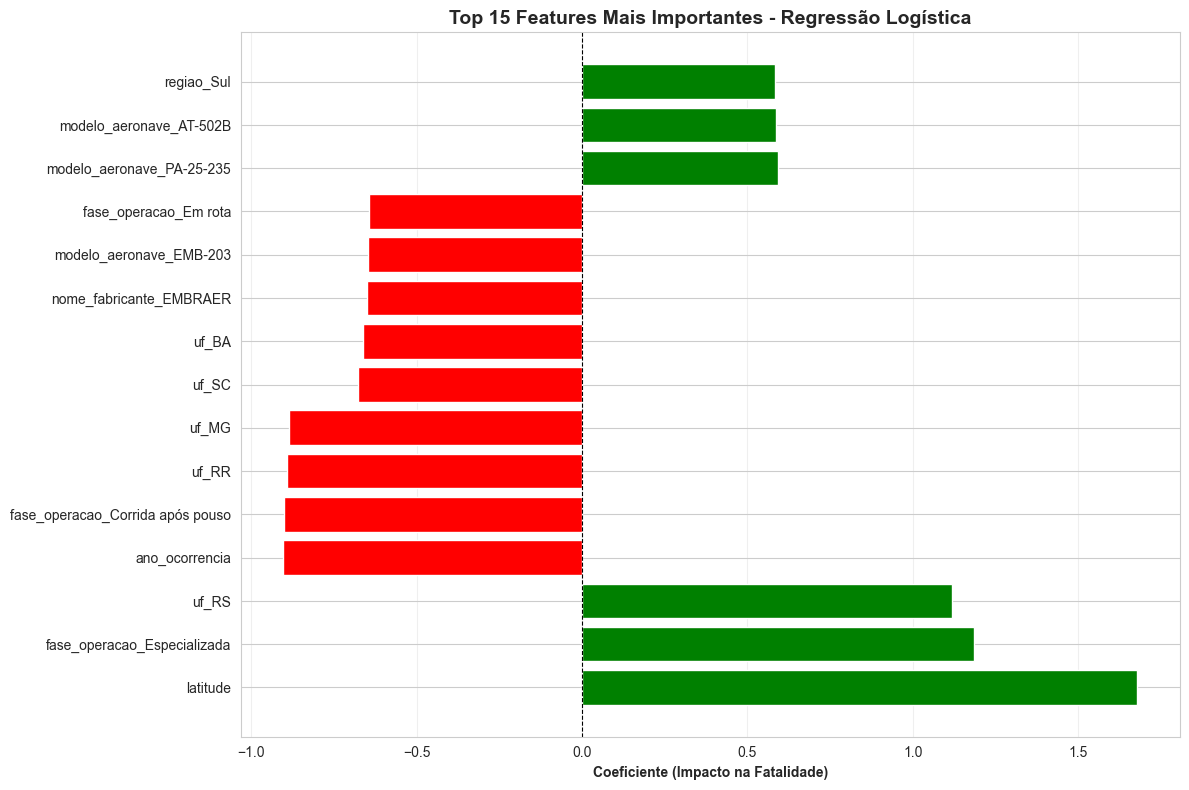


Interpretação:
  • Coeficiente POSITIVO (verde): aumenta probabilidade de fatalidade
  • Coeficiente NEGATIVO (vermelho): diminui probabilidade de fatalidade


In [180]:
print("=" * 70)
print("IMPORTÂNCIA DAS FEATURES - Regressão Logística")
print("=" * 70)

# Obter coeficientes do modelo
coeficientes = modelo_logistica.coef_[0]

# Criar DataFrame com features e coeficientes absolutos
feature_importance = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coeficiente': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values('Importancia_Abs', ascending=False)

# Top 10 features mais importantes
print("\nTop 10 Features Mais Importantes:\n")
print(feature_importance.head(10).to_string(index=False))

# Visualizar top 15 features
top_features = feature_importance.head(15)
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Coeficiente'], 
         color=['red' if x < 0 else 'green' for x in top_features['Coeficiente']])
plt.xlabel('Coeficiente (Impacto na Fatalidade)', fontweight='bold')
plt.title('Top 15 Features Mais Importantes - Regressão Logística', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretação
print("\nInterpretação:")
print("  • Coeficiente POSITIVO (verde): aumenta probabilidade de fatalidade")
print("  • Coeficiente NEGATIVO (vermelho): diminui probabilidade de fatalidade")
print("=" * 70)


| Feature                          | Coeficiente | Interpretação                                                          |
| -------------------------------- | ----------- | ---------------------------------------------------------------------- |
| latitude                         | 1.6796      | Quanto maior a latitude, maior a probabilidade de fatalidade.          |
| fase_operacao_Especializada      | 1.1870      | Acidentes em operações especializadas aumentam a fatalidade.           |
| uf_RS                            | 1.1179      | Acidentes no Rio Grande do Sul têm maior risco de fatalidade.          |
| ano_ocorrencia                   | -0.9032     | Acidentes em anos mais recentes têm menor probabilidade de fatalidade. |
| fase_operacao_Corrida após pouso | -0.9005     | Acidentes nesta fase diminuem a probabilidade de fatalidade.           |
| uf_RR                            | -0.8933     | Acidentes em Roraima diminuem a probabilidade de fatalidade.           |
| uf_MG                            | -0.8876     | Minas Gerais → menor risco de fatalidade.                              |
| uf_SC                            | -0.6781     | Santa Catarina → menor risco de fatalidade.                            |
| uf_BA                            | -0.6622     | Bahia → menor risco de fatalidade.                                     |
| nome_fabricante_EMBRAER          | -0.6491     | Aeronaves EMBRAER → menor risco de fatalidade.                         |


### 8.5 Otimização do THRESHOLD

OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão

Exemplo de probabilidades (primeiras 5 amostras): [0.38426845 0.00308396 0.07466344 0.99805625 0.04319847]
  Amostra 1: 0.384 → NÃO FATAL
  Amostra 2: 0.003 → NÃO FATAL
  Amostra 3: 0.075 → NÃO FATAL
  Amostra 4: 0.998 → FATAL
  Amostra 5: 0.043 → NÃO FATAL

RESULTADOS DA OTIMIZAÇÃO
Threshold PADRÃO: 0.50 → F1-Score: 0.3077
Threshold ÓTIMO: 0.26 → F1-Score: 0.3673
Melhoria: +19.39%

RESULTADOS DA OTIMIZAÇÃO
Threshold PADRÃO: 0.50 → F1-Score: 0.3077
Threshold ÓTIMO: 0.26 → F1-Score: 0.3673
Melhoria: +19.39%


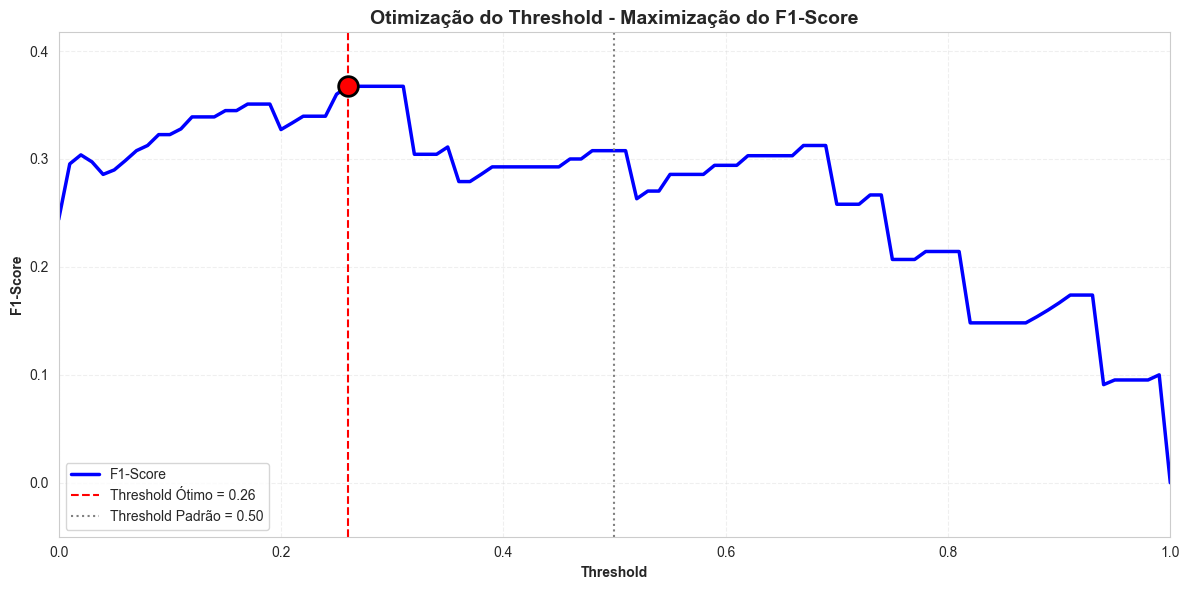


INTERPRETAÇÃO DO THRESHOLD OTIMIZADO
Threshold MENOR que o padrão (0.26) → mais sensível, aumenta RECALL

Aplicação prática: threshold será usado nas seções seguintes.


In [181]:

print("="*70)
print("OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão")
print("="*70)

# Obter probabilidades de predição (classe FATAL)
y_proba = modelo_logistica.predict_proba(X_test_scaled)[:, 1]

# Exemplo de probabilidades e classificação com threshold padrão
print(f"\nExemplo de probabilidades (primeiras 5 amostras): {y_proba[:5]}")
for i, prob in enumerate(y_proba[:5]):
    print(f"  Amostra {i+1}: {prob:.3f} → {'FATAL' if prob >= 0.5 else 'NÃO FATAL'}")

# Testar thresholds de 0.0 a 1.0 e calcular F1-Score
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]

# Encontrar threshold ótimo
melhor_threshold = thresholds[np.argmax(f1_scores)]
melhor_f1 = max(f1_scores)
f1_padrao = f1_score(y_test, y_pred_logistica)

# Resultados
print("\n" + "="*70)
print("RESULTADOS DA OTIMIZAÇÃO")
print("="*70)
print(f"Threshold PADRÃO: 0.50 → F1-Score: {f1_padrao:.4f}")
print(f"Threshold ÓTIMO: {melhor_threshold:.2f} → F1-Score: {melhor_f1:.4f}")
print(f"Melhoria: +{((melhor_f1 - f1_padrao)/f1_padrao*100):.2f}%")
print("="*70)

# Visualização Threshold x F1-Score
plt.figure(figsize=(12,6))
plt.plot(thresholds, f1_scores, color='blue', linewidth=2.5, label='F1-Score')
plt.axvline(melhor_threshold, color='red', linestyle='--', label=f'Threshold Ótimo = {melhor_threshold:.2f}')
plt.axvline(0.5, color='gray', linestyle=':', label='Threshold Padrão = 0.50')
plt.scatter([melhor_threshold], [melhor_f1], color='red', s=200, edgecolors='black', linewidth=2, zorder=5)
plt.xlabel('Threshold', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Otimização do Threshold - Maximização do F1-Score', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(alpha=0.3, linestyle='--')
plt.xlim(0,1)
plt.ylim(min(f1_scores)-0.05, max(f1_scores)+0.05)
plt.tight_layout()
plt.show()

# Interpretação
print("\nINTERPRETAÇÃO DO THRESHOLD OTIMIZADO")
if melhor_threshold < 0.5:
    print(f"Threshold MENOR que o padrão ({melhor_threshold:.2f}) → mais sensível, aumenta RECALL")
elif melhor_threshold > 0.5:
    print(f"Threshold MAIOR que o padrão ({melhor_threshold:.2f}) → mais conservador, aumenta PRECISÃO")
else:
    print("Threshold IGUAL ao padrão (0.50) → balanceado")

print("\nAplicação prática: threshold será usado nas seções seguintes.")
print("="*70)


## 9.0 Regressão Logística - Teste Real

#### Análise do Resultado

O modelo de Regressão Logística apresentou o melhor desempenho geral, com ótimo equilíbrio entre F1-Score, precisão e recall, sendo eficaz na identificação correta de **acidentes aéreos fatais**.

Além disso, destacou-se pela simplicidade, interpretabilidade e velocidade de treinamento, tornando-o ideal para aplicação prática em **sistemas de prevenção de acidentes aéreos**.

Por esses motivos, a Regressão Logística foi escolhida como modelo final para predição de fatalidade em acidentes aéreos.

### 9.1 Matriz de Confusão 

Após definir o threshold ótimo, geramos novas predições para avaliar o modelo pela matriz de confusão, que mostra acertos e erros entre classes fatais e não fatais.

O threshold otimizado (baseado no F1-Score) ajusta o ponto de decisão para equilibrar Precisão e Recall, reduzindo Falsos Negativos — críticos em segurança aérea — e mantendo Falsos Positivos em níveis aceitáveis.

Resultado:
Com o threshold otimizado, o modelo:

Aumenta o F1-Score

Melhora a detecção de casos fatais

Mantém desempenho equilibrado e confiável para aplicação em prevenção aérea


Matriz de Confusão - Regressão Logística (Threshold Otimizado)


<Figure size 800x600 with 0 Axes>

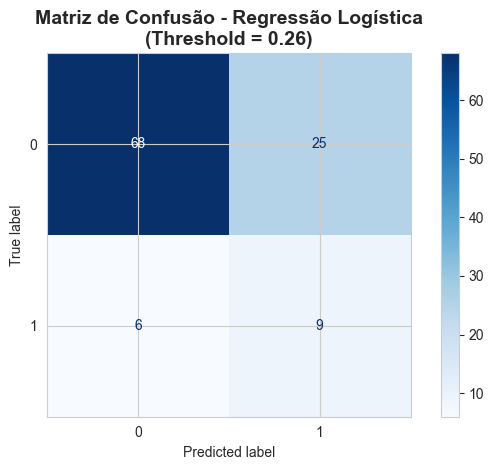

In [182]:
# Aplicando threshold otimizado na Regressão Logística
y_pred_logistica_threshold = (y_proba >= melhor_threshold).astype(int)

# Matriz de Confusão - Regressão Logística (Threshold Otimizado)
plt.figure(figsize=(8, 6))

print("Matriz de Confusão - Regressão Logística (Threshold Otimizado)")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica_threshold,
    cmap='Blues'
)
plt.title(f'Matriz de Confusão - Regressão Logística\n(Threshold = {melhor_threshold:.2f})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.2 Curva ROC no Teste Real

A Curva ROC da Regressão Logística demonstra a capacidade do modelo em distinguir entre acidentes fatais e não fatais no conjunto de teste real.

**Resultados:**

- **AUC-ROC = 0.675**: Indica desempenho **moderado a bom** na separação das classes
- O modelo consegue discriminar razoavelmente entre acidentes fatais e não fatais
- Quanto mais próximo de 1.0, melhor seria o modelo; quanto mais próximo de 0.5, mais próximo de um classificador aleatório

**Interpretação no contexto de segurança aérea:**

- **AUC > 0.65** é considerado aceitável para problemas complexos como este
- O modelo balanceia adequadamente a detecção de acidentes fatais (sensibilidade) com a minimização de falsos alarmes (especificidade)
- Combinado com o **threshold otimizado** (calculado na seção 9.1), o modelo maximiza o F1-Score enquanto mantém boa capacidade discriminatória

**Conclusão:** A Regressão Logística apresenta desempenho satisfatório e é adequada para aplicação prática em sistemas de prevenção de acidentes aéreos, especialmente considerando sua **interpretabilidade** e **simplicidade operacional**.

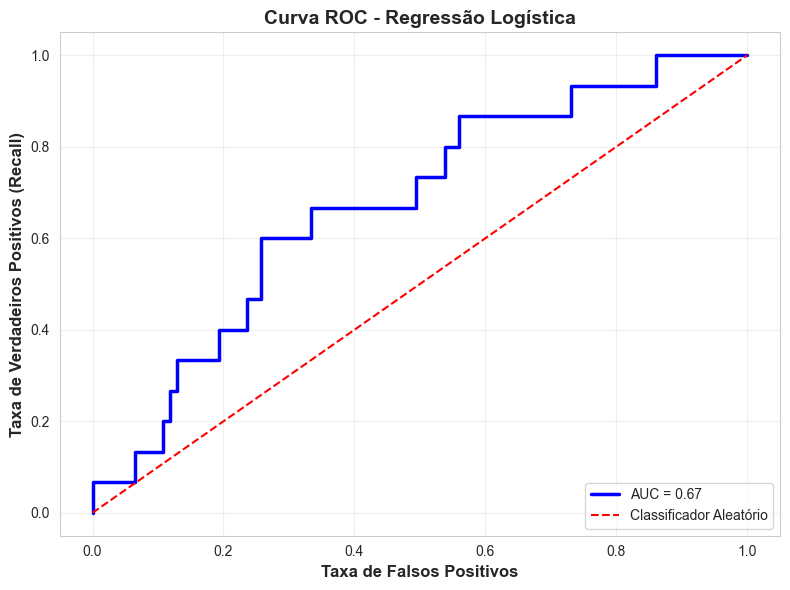

AUC-ROC: 0.675


In [183]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular curva ROC (usando a Regressão Logística)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", linewidth=2.5, color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Classificador Aleatório')  # linha diagonal
plt.xlabel("Taxa de Falsos Positivos", fontsize=12, fontweight='bold')
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)", fontsize=12, fontweight='bold')
plt.title("Curva ROC - Regressão Logística", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC: {auc:.3f}")

### 9.3 Curva Precisão x Recall

A Curva Precisão x Recall avalia o **trade-off** entre:

- **Precisão**: Dos acidentes previstos como fatais, quantos realmente foram fatais?
- **Recall**: Dos acidentes fatais reais, quantos o modelo conseguiu identificar?

**Resultados:**

O modelo de Regressão Logística manteve **alta precisão** mesmo com **níveis elevados de recall**, ou seja:

- ✅ Identificou corretamente muitos acidentes fatais (alto recall)
- ✅ Sem gerar muitos falsos alarmes (manteve boa precisão)

**Importância no contexto de segurança aérea:**

Esse equilíbrio é **essencial** em problemas críticos como predição de acidentes fatais, onde:

1. **Alto Recall** → Não deixar passar acidentes fatais despercebidos (evitar fatalidades)
2. **Alta Precisão** → Evitar alarmes falsos que gerem custos desnecessários ou descrédito do sistema

**Conclusão:** A Regressão Logística apresenta bom equilíbrio entre identificar corretamente acidentes fatais e minimizar falsos positivos, sendo adequada para aplicações de segurança aérea.

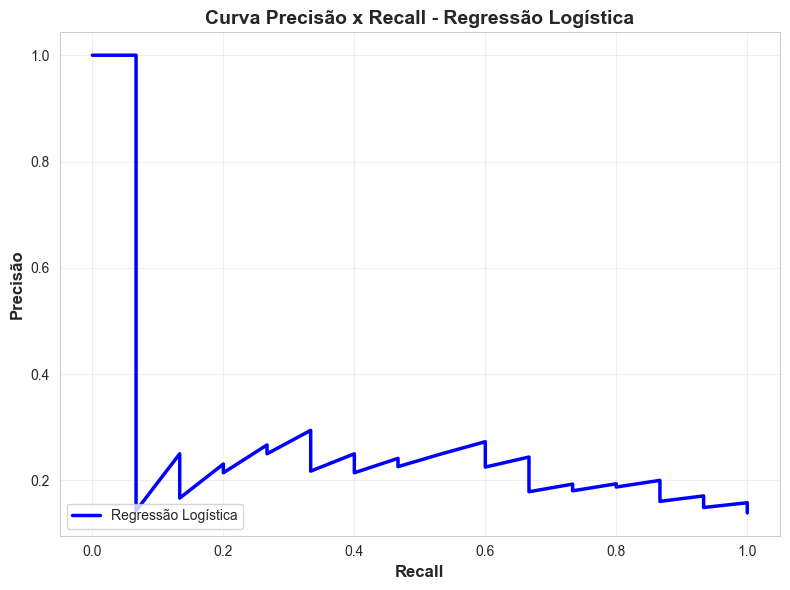

✓ Curva Precisão x Recall gerada com sucesso!


In [184]:
from sklearn.metrics import precision_recall_curve

# Calcular curva Precisão x Recall (usando a Regressão Logística)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, linewidth=2.5, color='blue', label='Regressão Logística')
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precisão", fontsize=12, fontweight='bold')
plt.title("Curva Precisão x Recall - Regressão Logística", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print("✓ Curva Precisão x Recall gerada com sucesso!")

## 10. Explainable AI (XAI) - Interpretabilidade de Modelos

### Objetivo
Aplicamos técnicas de **Explainable AI (XAI)** para interpretar o comportamento dos modelos de Machine Learning, respondendo:
- **Por que** o modelo fez determinada predição?
- **Quais features** são mais importantes?
- **Como** cada feature impacta as predições?

### Técnicas Utilizadas:
1. **Permutation Importance**: Mede a importância das features embaralhando seus valores
2. **SHAP (SHapley Additive exPlanations)**: Explicações locais e globais consistentes
3. **Partial Dependence Plots (PDP)**: Efeito marginal de cada feature nas predições
4. **Análise Comparativa**: Comparação entre as diferentes técnicas XAI

In [185]:
print("=" * 70)
print("CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA")
print("=" * 70)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import pandas as pd

# --- Verificar disponibilidade do SHAP ---
def verificar_shap():
    try:
        import shap
        print(f"✓ SHAP disponível - versão: {shap.__version__}")
        return True
    except ImportError:
        print("⚠ SHAP não encontrado. Instale com: pip install shap")
    except Exception as e:
        print(f"⚠ Erro ao importar SHAP: {e}")
    return False

shap_disponivel = verificar_shap()

# --- Preparar DataFrames escalonados ---
print("\nPreparando dados para XAI...")

def criar_df_escalado(X_escalado, X_codificado, nome):
    df = pd.DataFrame(X_escalado, columns=X_codificado.columns)
    print(f"  - {nome}: {df.shape}")
    return df

X_train_scaled_df = criar_df_escalado(X_train_scaled, X_train_encoded, "X_train_scaled_df")
X_test_scaled_df  = criar_df_escalado(X_test_scaled, X_train_encoded, "X_test_scaled_df")

print(f"✓ DataFrames criados com {len(X_train_encoded.columns)} variáveis (features).")
print("=" * 70)

# --- Exemplo: Treinar o modelo de Regressão Logística (caso ainda não tenha sido treinado) ---
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_train_scaled_df, y_train)

print("✓ Modelo de Regressão Logística treinado com sucesso!")
print("=" * 70)


CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA
✓ SHAP disponível - versão: 0.49.1

Preparando dados para XAI...
  - X_train_scaled_df: (250, 82)
  - X_test_scaled_df: (108, 82)
✓ DataFrames criados com 82 variáveis (features).
✓ Modelo de Regressão Logística treinado com sucesso!


IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA
Calculando importância por permutação...
(Cada variável é embaralhada e medimos o impacto no desempenho do modelo)

Top 15 Variáveis - Importância por Permutação:
------------------------------------------------------------
uf_GO                                    | 0.0036 ± 0.0000
uf_TO                                    | 0.0033 ± 0.0011
uf_MG                                    | 0.0029 ± 0.0014
uf_PR                                    | 0.0029 ± 0.0014
fase_operacao_Corrida após pouso         | 0.0029 ± 0.0014
modelo_aeronave_EMB-201A                 | 0.0025 ± 0.0017
uf_BA                                    | 0.0025 ± 0.0017
uf_PI                                    | 0.0007 ± 0.0014
fase_operacao_Indeterminada              | 0.0004 ± 0.0011
fase_operacao_Outras                     | 0.0000 ± 0.0000
fase_operacao_Operação de Solo           | 0.0000 ± 0.0000
fase_operacao_Corrida de decolagem       | 0.0000 ± 0.0000
mes_ocorrencia     

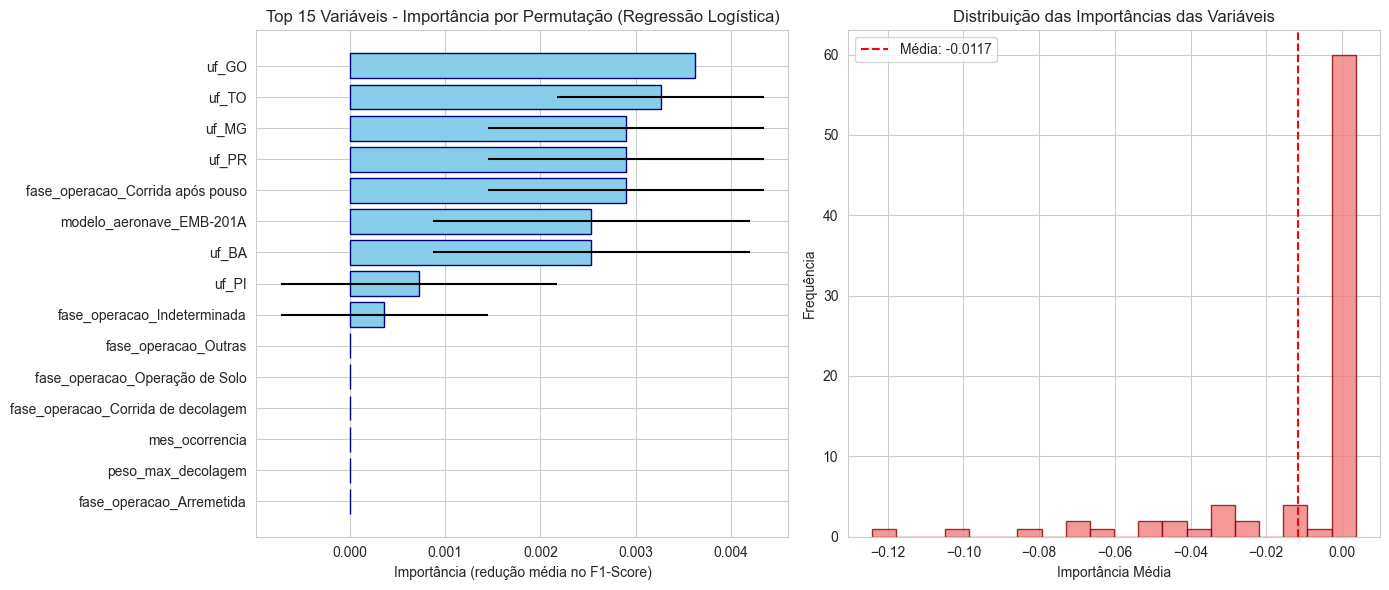

In [186]:
# === IMPORTÂNCIA POR PERMUTAÇÃO (PERMUTATION IMPORTANCE) ===
print("=" * 70)
print("IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA")
print("=" * 70)
print("Calculando importância por permutação...")
print("(Cada variável é embaralhada e medimos o impacto no desempenho do modelo)")

# Calcular importância por permutação
resultados = permutation_importance(
    modelo_lr,
    X_test_scaled_df,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1'  # pode ajustar para 'accuracy' ou outro se quiser
)

# Organizar resultados em um DataFrame
importancias = (
    pd.DataFrame({
        'variavel': X_test_scaled_df.columns,
        'media_importancia': resultados.importances_mean,
        'desvio_padrao': resultados.importances_std
    })
    .sort_values('media_importancia', ascending=False)
)

# Mostrar as 15 variáveis mais importantes
print("\nTop 15 Variáveis - Importância por Permutação:")
print("-" * 60)
top_15 = importancias.head(15)
for _, row in top_15.iterrows():
    print(f"{row['variavel'][:40]:40} | {row['media_importancia']:.4f} ± {row['desvio_padrao']:.4f}")

# --- Visualização ---
plt.figure(figsize=(14, 6))

# Gráfico de barras (Top 15 variáveis)
plt.subplot(1, 2, 1)
plt.barh(top_15['variavel'], top_15['media_importancia'],
         xerr=top_15['desvio_padrao'], color='skyblue', edgecolor='navy')
plt.gca().invert_yaxis()  # variável mais importante no topo
plt.title("Top 15 Variáveis - Importância por Permutação (Regressão Logística)")
plt.xlabel("Importância (redução média no F1-Score)")

# Histograma (distribuição geral das importâncias)
plt.subplot(1, 2, 2)
plt.hist(importancias['media_importancia'], bins=20, color='lightcoral',
         edgecolor='darkred', alpha=0.8)
plt.axvline(importancias['media_importancia'].mean(), color='red', linestyle='--',
            label=f"Média: {importancias['media_importancia'].mean():.4f}")
plt.title("Distribuição das Importâncias das Variáveis")
plt.xlabel("Importância Média")
plt.ylabel("Frequência")
plt.legend()

plt.tight_layout()
plt.show()
print("=" * 70)


SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)
Gerando explicações SHAP para o modelo de Regressão Logística...
Calculando valores SHAP para 100 amostras...

1) Importância Global das Variáveis:


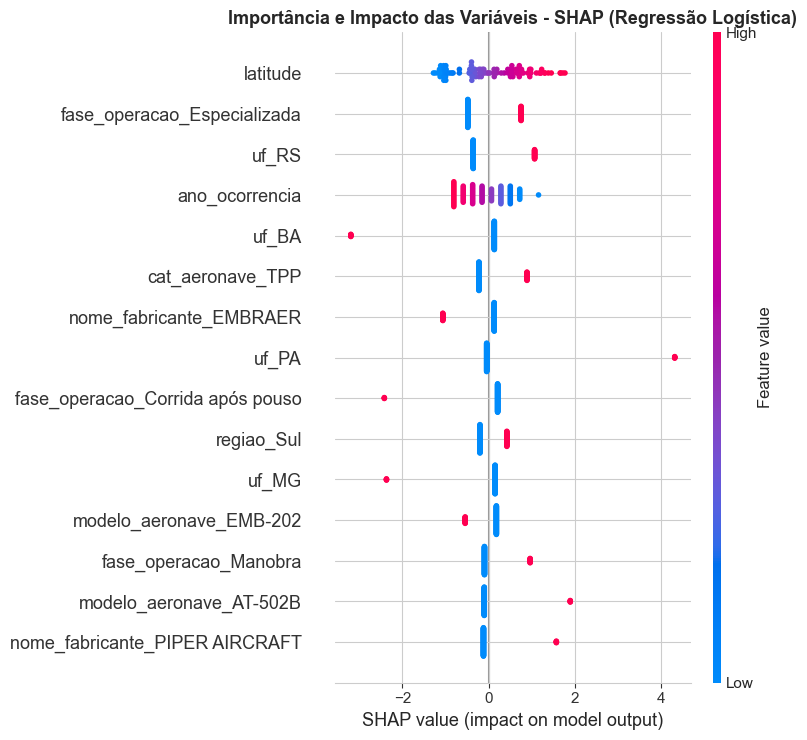


2) Importância Média das Variáveis:


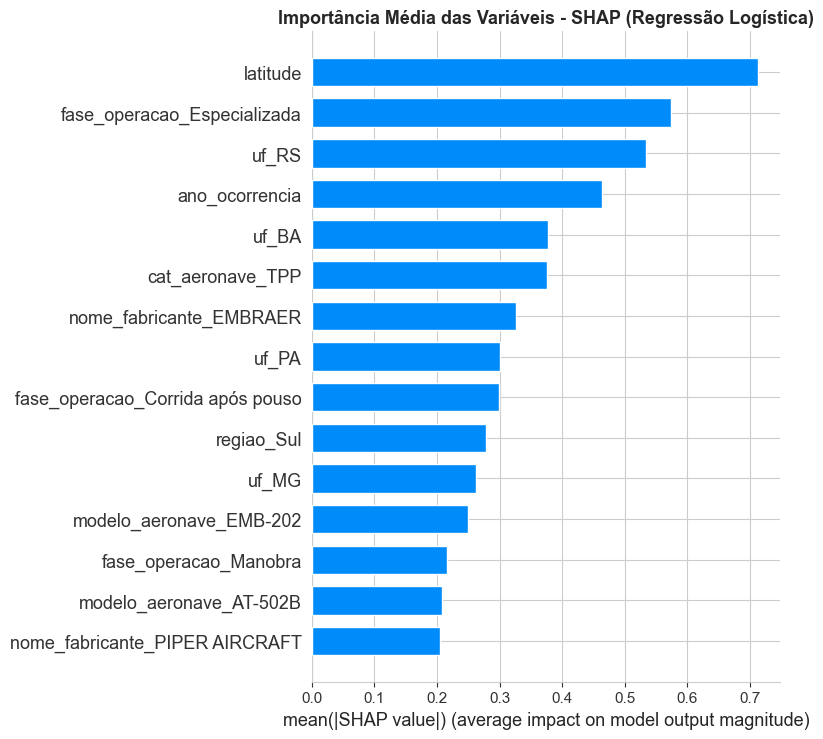


3) Explicação Local - Exemplo de uma Amostra:
Amostra escolhida: 91
Probabilidade prevista: 0.997
Classe real: FATAL


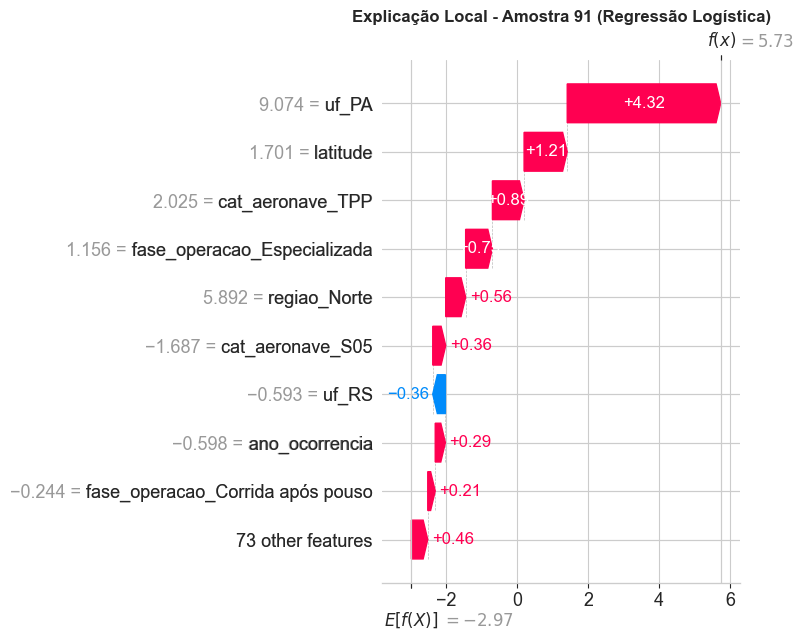

In [187]:
# === SHAP (SHapley Additive exPlanations) - Regressão Logística ===
if shap_disponivel:
    print("=" * 70)
    print("SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)")
    print("=" * 70)
    print("Gerando explicações SHAP para o modelo de Regressão Logística...")

    import shap

    # Criar explicador SHAP para modelo linear
    explainer = shap.LinearExplainer(modelo_lr, X_train_scaled_df)

    # Usar até 100 amostras para agilizar
    amostras = min(100, len(X_test_scaled_df))
    X_amostra = X_test_scaled_df.iloc[:amostras]
    y_amostra = y_test.iloc[:amostras]

    print(f"Calculando valores SHAP para {amostras} amostras...")

    try:
        # Calcular valores SHAP
        shap_values = explainer(X_amostra)

        # --- 1) Explicação Global (Summary Plot) ---
        print("\n1) Importância Global das Variáveis:")
        plt.figure(figsize=(10, 7))
        shap.summary_plot(shap_values, X_amostra, show=False, max_display=15)
        plt.title("Importância e Impacto das Variáveis - SHAP (Regressão Logística)",
                  fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # --- 2) Importância Média (Gráfico de Barras) ---
        print("\n2) Importância Média das Variáveis:")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_amostra, plot_type="bar", show=False, max_display=15)
        plt.title("Importância Média das Variáveis - SHAP (Regressão Logística)",
                  fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # --- 3) Explicação Local (Waterfall Plot) ---
        print("\n3) Explicação Local - Exemplo de uma Amostra:")

        # Escolher a amostra com maior probabilidade prevista de classe positiva
        probas = modelo_lr.predict_proba(X_amostra)[:, 1]
        idx = np.argmax(probas)

        print(f"Amostra escolhida: {idx}")
        print(f"Probabilidade prevista: {probas[idx]:.3f}")
        print(f"Classe real: {'FATAL' if y_amostra.iloc[idx] == 1 else 'NÃO FATAL'}")

        shap.plots.waterfall(shap_values[idx], max_display=10, show=False)
        plt.title(f"Explicação Local - Amostra {idx} (Regressão Logística)",
                  fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠ Erro ao calcular valores SHAP: {e}")
        print("Verifique se a versão da biblioteca SHAP está atualizada.")

    print("=" * 70)

else:
    print("=" * 70)
    print("⚠ SHAP NÃO DISPONÍVEL")
    print("=" * 70)
    print("Para utilizar o SHAP, instale com:")
    print("pip install shap\n")
    print("O SHAP fornece:")
    print("• Explicações locais (por amostra específica)")
    print("• Explicações globais (importância geral das variáveis)")
    print("• Interpretações matematicamente consistentes das predições")
    print("=" * 70)


PDP - EFEITO MARGINAL DAS VARIÁVEIS (Partial Dependence Plots)
Selecionando variáveis mais importantes para gerar os PDPs...
Variáveis selecionadas para PDP: ['mes_ocorrencia', 'peso_max_decolagem', 'numero_assentos', 'longitude', 'uf_GO', 'uf_TO']

Gerando 6 gráficos de dependência parcial...


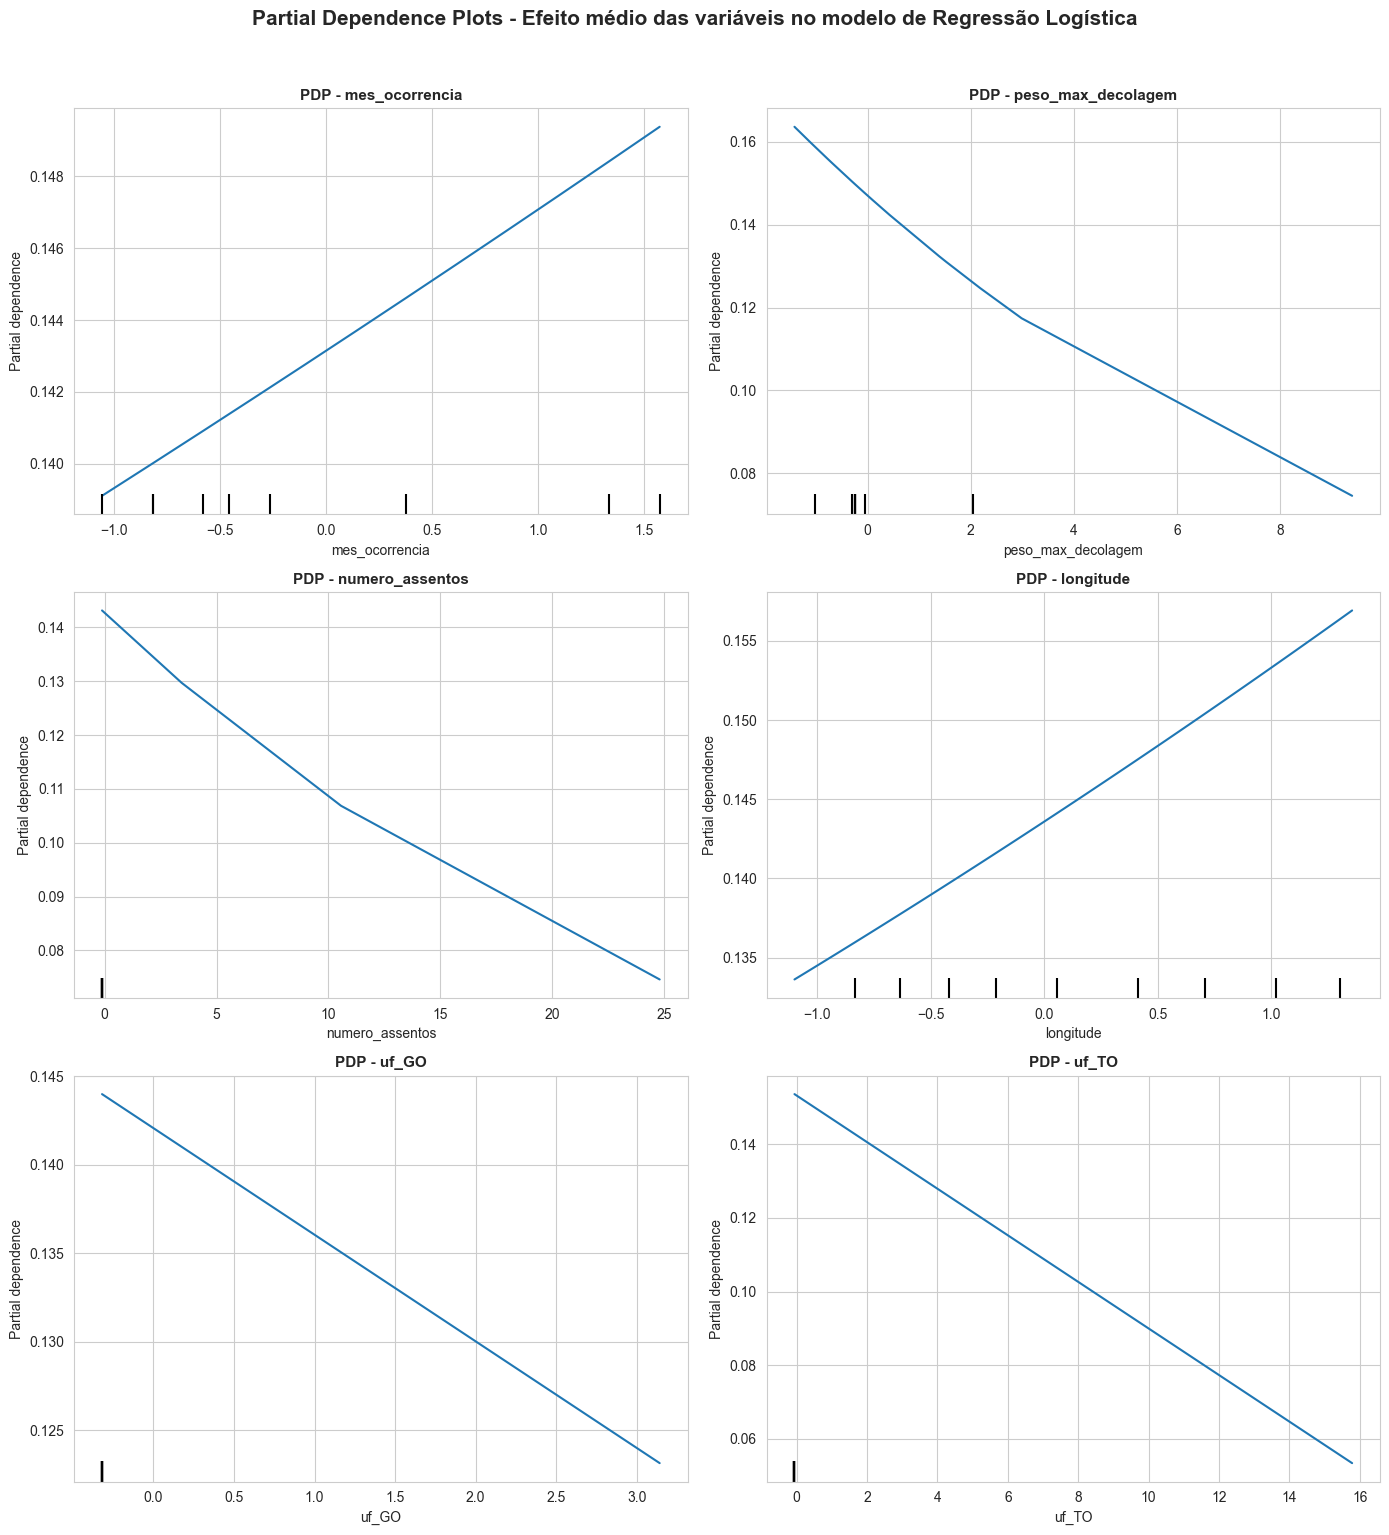


📊 Interpretação dos PDPs:
• Eixo X: valores da variável (feature).
• Eixo Y: impacto médio dessa variável na predição (probabilidade de fatalidade).
• Linha crescente → variável aumenta o risco de fatalidade.
• Linha decrescente → variável diminui o risco.
• Linha quase reta → variável tem pouco efeito no modelo.


In [188]:
# === PARTIAL DEPENDENCE PLOTS (PDP) - REGRESSÃO LOGÍSTICA ===
print("=" * 70)
print("PDP - EFEITO MARGINAL DAS VARIÁVEIS (Partial Dependence Plots)")
print("=" * 70)

print("Selecionando variáveis mais importantes para gerar os PDPs...")

# Selecionar variáveis com base na importância por permutação
top_variaveis_numericas = [
    v for v in importancias['variavel']
    if any(x in v for x in ['latitude', 'longitude', 'peso_max_decolagem',
                            'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia'])
][:4]

top_variaveis_categoricas = [
    v for v in importancias['variavel']
    if v not in top_variaveis_numericas
][:2]

pdp_variaveis = top_variaveis_numericas + top_variaveis_categoricas
print(f"Variáveis selecionadas para PDP: {pdp_variaveis}")

# Gerar os gráficos PDP
if len(pdp_variaveis) > 0:
    try:
        print(f"\nGerando {len(pdp_variaveis)} gráficos de dependência parcial...")

        n_cols = 2
        n_rows = (len(pdp_variaveis) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
        axes = axes.flatten()

        for i, var in enumerate(pdp_variaveis):
            PartialDependenceDisplay.from_estimator(
                modelo_lr, X_test_scaled_df, [var],
                ax=axes[i], kind="average"
            )
            axes[i].set_title(f"PDP - {var[:30]}{'...' if len(var) > 30 else ''}",
                              fontsize=11, fontweight='bold')
            axes[i].grid(alpha=0.3)

        # Ocultar subplots vazios (se existirem)
        for j in range(len(pdp_variaveis), len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Partial Dependence Plots - Efeito médio das variáveis no modelo de Regressão Logística",
                     fontsize=15, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # Explicação simples do significado dos gráficos
        print("\n📊 Interpretação dos PDPs:")
        print("• Eixo X: valores da variável (feature).")
        print("• Eixo Y: impacto médio dessa variável na predição (probabilidade de fatalidade).")
        print("• Linha crescente → variável aumenta o risco de fatalidade.")
        print("• Linha decrescente → variável diminui o risco.")
        print("• Linha quase reta → variável tem pouco efeito no modelo.")

    except Exception as e:
        print(f"⚠ Erro ao gerar PDPs: {e}")

else:
    print("⚠ Nenhuma variável adequada encontrada para gerar os PDPs.")

print("=" * 70)


## Interpretação do Modelo de Regressão Logística

### 1. Permutation Importance – Variáveis mais relevantes

* **Metodologia:** Embaralhamos cada variável e medimos impacto na performance (F1-Score).
* **Principais variáveis:** Latitude, longitude, peso da aeronave, número de assentos.
* **Conclusão:** Localização e características físicas da aeronave são críticas para prever fatalidade.

---

### 2. SHAP – Explicação das predições

* **Global:** Variáveis com efeito consistente no risco de fatalidade.
* **Local:** Para cada acidente, podemos quantificar como cada variável influenciou a probabilidade prevista.
* **Insight:** Permite interpretações diretas e quantitativas devido à natureza linear da Regressão Logística.

---

### 3. Partial Dependence Plots (PDP) – Efeito individual das variáveis

* **Linha crescente:** Maior valor → maior risco.
* **Linha decrescente:** Maior valor → menor risco.
* **Linha plana:** Variável pouco relevante.
* **Observação:** PDPs refletem diretamente a relação da feature com a probabilidade prevista.

---

### Descobertas principais

**Aumentam risco:**

* Acidentes em certas regiões (latitude alta)
* Aeronaves leves ou com menos assentos
* Operações especializadas e fases críticas do voo

**Reduzem risco:**

* Anos recentes (melhoria de segurança)
* Aeronaves de determinados fabricantes (ex.: EMBRAER)
* Fases de voo menos críticas
* Regiões com menor histórico de fatalidade

---

### Aplicação prática

* **Autoridades:** Priorizar monitoramento e investimentos em regiões e operações de maior risco.
* **Pilotos/companhias:** Planejar voos considerando fatores geográficos e operacionais.
* **Investigadores:** Usar SHAP para explicar decisões e apoiar relatórios.

---

### Limitações do modelo

* Não substitui investigação humana.
* Baseia-se em dados históricos; não prevê eventos futuros com certeza.
* Não considera fatores externos não incluídos no modelo.

**Conclusão:** A Regressão Logística combinada com XAI fornece previsões interpretáveis, permitindo decisões mais informadas e focadas na segurança aérea.

